In [68]:
class Solution:
    def climbStairs(self , n ):
        # write code here
        if n==1: return 1
        elif n==2: return 2
        else:
            return climbStairs(n-1)+climbStairs(n-2)
s = Solution()

In [69]:
s.climbStairs(3)

NameError: name 'climbStairs' is not defined

In [70]:
a = [1,2,3,4,]

In [71]:
del a[0], a[3]

IndexError: list assignment index out of range

In [62]:
# this code is for draw the performance graph of ODE under Central model
# 2020-8-17 need to add states to represent the system

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sympy as sp
from math import factorial, isclose
from tqdm import tqdm
import csv
from scipy.sparse import csr_matrix
from scipy.sparse import identity
from scipy.sparse.linalg import spsolve, dsolve, isolve
from collections import deque
from time import time
import seaborn as sns
from tqdm import tqdm_notebook as tqdm
import random

In [50]:
Instance = 4
np.random.seed(Instance)
random.seed(0)
A = 2
M = 8
def getPij(a):
    temp = np.log1p(np.random.rand(A, A))
    return (temp / sum(temp)).T
Pij = getPij(A)
ArrLst = np.log1p(np.random.rand(A))
Beta = 0.4
Gamma = 1
Mu = 1
N = 1
Delta = 1
B_, D_ = 2, 2
RhoMtx = [[1.0, 0.5],
          [0.5, 1.0]]
# RhoMtx = [[1/(abs(j-i)+1) for i in range(A)] for j in range(A)]

In [60]:
class perfCenODE():
    def __init__(self, A, M, Pij, ArrLst, RhoMtx, Beta, B_, Gamma, Mu, N, Delta, D_):
        # init parameters
        self.A, self.M, self.Pij, self.ArrLst, self.RhoMtx, self.Beta, self.B_, self.Gamma, self.Mu, self.N, self.Delta, self.D_ = \
            A, M, Pij, ArrLst, RhoMtx, Beta, B_, Gamma, Mu, N, Delta, D_
        # init state dict
        self.State = self.getStateDict()
        self.n_state = len(self.State)

    def getStateDict(self):
        # generate state dictionary direrctly
        def getState(a, m):
            A, M = a, m
            State = {}
            index = [0]

            def temp(x, i, index):
                x.append(i)
                generate_R(x.copy(), index)

            def generate_R(s, index):
                if len(s) == A + 3 + A ** 2 and sum(s) == M:
                    State[tuple(s)] = index[0]
                    index[0] += 1
                elif len(s) > A + 3 + A ** 2 or sum(s) > M:
                    return 0
                else:
                    for i in range(M + 1):
                        temp(s.copy(), i, index)

            for i in range(M + 1):
                generate_R([i], index)

            return State

        State = getState(self.A, self.M)
        # print('getState done!')
        return State

    def getMtx(self):
        State = self.State
        n_state = self.n_state

        def get_target_number():
            A, M, D_, ArrLst = self.A, self.M, self.D_, self.ArrLst
            arr = np.array(ArrLst) / sum(ArrLst)
            num_dis = [int(M * x) for x in arr]
            left = M - sum(num_dis)
            for i in np.argsort(ArrLst)[:left]:
                num_dis[i] += 1
            return num_dis
        self.num_dis = get_target_number()

        def get_before_reallocate(arr_rank, num_dis, N_lst, dbar, result_lst):
            # if dbar == 0: return result_lst
            # print(arr_rank, num_dis, N_lst, dbar, result_lst)
            i = arr_rank[0]
            if N_lst[i] < num_dis[i]:
                if dbar <= N_lst[i]:
                    result = N_lst.copy()
                    result[i] -= dbar
                    result_lst.append(result)
            elif N_lst[i] > num_dis[i]:
                if arr_rank.size != 0:
                    get_before_reallocate(arr_rank[1:], num_dis, N_lst, dbar, result_lst)
            else:
                if arr_rank.size == 1:
                    if N_lst[i] >= dbar:
                        result = N_lst.copy()
                        result[i] -= dbar
                        result_lst.append(result)
                else:
                    for j in range(min(N_lst[i], dbar) + 1):
                        arr_rank1 = arr_rank[1:]
                        result = N_lst.copy()
                        result[i] -= j
                        #dbar -= j
                        get_before_reallocate(arr_rank1, num_dis, result, dbar-j, result_lst)

        #         A, M, Pij, ArrLst, RhoMtx, Beta, B_, Gamma, Mu, N, Delta, D_ = \
        #         self.A, self.M, self.Pij, self.ArrLst, self.RhoMtx, self.Beta, self.B_, self.Gamma, self.Mu, self.N, self.Delta, self.D_
        def INi(ni):
            if ni > 0: return 1
            else: return 0
        def IBP(s):
            if s[-3] >= self.B_ or (sum(s[-3:]) == self.M and s[-3] > 0): return 1
            else: return 0
        def IDP(s):
            if s[-1] >= self.D_ or (sum(s[-3:]) == self.M and s[-1] > 0): return 1
            else: return 0
        def IS(s):
            if tuple(s) in State.keys(): return 1
            else: return 0

        def arrRateIn(s):
            n, col, val = 0, [], []
            for i in range(self.A):
                for j in range(self.A):
                    tempS = list(s)
                    # Ni, Rij
                    y = self.A + i * self.A + j
                    a1 = tempS[i] = tempS[i] + 1
                    a2 = tempS[y] = tempS[y] - 1
                    if IS(tempS):
                        n += 1
                        col.append(State[tuple(tempS)])
                        val.append(self.ArrLst[i] * self.Pij[i][j])
            #         print(tempS)
            # print(n, col, val)
            # print('arr-----------')
            return n, col, val

        def backRateIn(s):
            n, col, val = 0, [], []
            for i in range(self.A):
                for j in range(self.A):
                    tempS = list(s)
                    # Ni, Rij
                    y = self.A + j * self.A + i
                    a1 = tempS[i] = tempS[i] - 1
                    a2 = tempS[y] = tempS[y] + 1
                    if IS(tempS):
                        n += 1
                        col.append(State[tuple(tempS)])
                        val.append(self.RhoMtx[j][i] * a2 * (1 - self.Beta))
            #         print(tempS)
            # print(n, col, val)
            # print('back-----------')
            return n, col, val

        def broRateIn(s):
            n, col, val = 0, [], []
            for i in range(self.A):
                for j in range(self.A):
                    tempS = list(s)
                    # Rij, BP
                    y = self.A + i * self.A + j
                    a1 = tempS[y] = tempS[y] + 1
                    a2 = tempS[-3] = tempS[-3] - 1
                    if IS(tempS):
                        n += 1
                        col.append(State[tuple(tempS)])
                        val.append(self.RhoMtx[i][j] * a1 * self.Beta)
            #         print(tempS)
            # print(n, col, val)
            # print('bro-----------')
            return n, col, val

        def gathRateIn(s):
            n, col, val = 0, [], []
            tempS = list(s)
            b = []
            # BP, RC
            if s[-2]>0: # only if there exists bikes being repaired
                for i in range(min(s[-2], self.B_)):
                    b += [i+1]
                for j in b:
                    tempS[-3] += j
                    tempS[-2] -= j
                    if IS(tempS):
                        n += 1
                        col.append(State[tuple(tempS)])
                        val.append(self.Gamma)
            return n, col, val

        def fixRateIn(s):
            n, col, val = 0, [], []
            tempS = list(s)
            # RC, DP
            a1 = tempS[-2] = tempS[-2] + 1
            a2 = tempS[-1] = tempS[-1] - 1
            if IS(tempS):
                n += 1
                col.append(State[tuple(tempS)])
                val.append(self.Mu * min(a1, self.N))
            # print(tempS)
            # print(n, col, val)
            # print('fix-----------')
            return n, col, val

        def redRateIn(s):
            n, col, val = 0, [], []
            if sum(s[-3:]) == self.M: return n, col, val
            tempS = list(s)
            A, D_, num_dis = self.A, self.D_, self.num_dis
            # DP, Ni
            arr_rank, N_lst1, dbar1, result_lst = np.argsort(self.ArrLst)[::-1], tempS[:A], D_, []
            get_before_reallocate(arr_rank, num_dis, N_lst1, dbar1, result_lst)
            tempS[-1] += D_
            tail = tempS[A:]
            for x in result_lst:
                temp = x + tail
                if IS(temp):
                    n += 1
                    col.append(State[tuple(temp)])
                    val.append(Delta)
            # print(tempS)
            # print(n, col, val)
            # print('red-----------')
            del arr_rank, N_lst1, dbar1, result_lst, tail
            return n, col, val

        def getRateOut(s):
            outRate = 0
            for i in range(self.A):
                if INi(s[i]):
                    outRate += self.ArrLst[i]
                else:
                    continue
            for i in range(self.A):
                for j in range(self.A):
                    outRate += self.RhoMtx[i][j] * s[self.A + i * self.A + j]
            outRate += self.Gamma * IBP(s) + self.Mu * min(s[-2], self.N) + self.Delta * IDP(s)
            # inRate += sum(list(map(lambda a: a[0]*a[1], zip(x,y))))
            return -outRate

        def getRateIn(s):
            n, col, val = 0, [], []
            '''
            # customer arrival: arrRateIn
            # ride back: backRateIn
            # ride break down: broRateIn
            # gathering: gathRateIn
            # fixing: fixRateIn
            # redistributing: redRateIn
            '''
            for f in [arrRateIn, backRateIn, broRateIn, gathRateIn, fixRateIn, redRateIn]:
                tempN, tempCol, tempVal = f(s)
                n += tempN
                col += tempCol
                val += tempVal

            return n, col, val

        def generateR():
            # R = csr_matrix((S,S), dtype=np.float)
            Row, Col, Value = [], [], []
            for k, s in enumerate(State):
                '''
                number of row: n
                row number: k
                column number: col
                value: data
                '''
                # 加1
                if k == n_state - 1:  # collect the last row as a test instance
                    tempN, tempCol, tempVal = getRateIn(s)
                    tempCol += [k]
                    tempVal += [getRateOut(s)]
                else:  # generate the mtx
                    # set rate out for state s
                    Row += [k]
                    Col += [k]
                    Value += [getRateOut(s)]

                    # set rate in for state s
                    tempN, tempCol, tempVal = getRateIn(s)
                    Row += [k] * tempN
                    Col += tempCol
                    Value += tempVal

            Row += [k] * n_state
            Col += list(range(n_state))
            Value += [1] * n_state
            R = csr_matrix((Value, (Row, Col)), dtype=np.float)  # .toarray()
            testArr = csr_matrix((tempVal, ([0] * (tempN + 1), tempCol)), dtype=np.float)
            return R, testArr

        return generateR()

    def getPortionState(self):
        BalanceMtx, testArr = self.getMtx()
        # print('getMtx done!')
        b = np.array([0] * (self.n_state - 1) + [1])
        x = spsolve(BalanceMtx, b)
        # %time x = dsolve.spsolve(BalanceMtx, b, use_umfpack=True)
        # %time x = dsolve.spsolve(BalanceMtx, b, use_umfpack=False)
        # x = isolve.cg(A=BalanceMtx, b=b)
        # assert(BalanceMtx.toarray()[-1].dot(x) == 1.0 and testArr.toarray().dot(x) == 0)
        portionState = {}
        for k, s in enumerate(self.State):
            portionState[s] = x[k]
        return portionState

    def getPerf(self, para):
        def getLost(state):
            _sum = 0.0
            for n, s in enumerate(range(self.A)):
                if state[n] == 0:
                    _sum += self.ArrLst[n]
            return _sum / sum(self.ArrLst)

        #         def getResult(n,b,l,i,B,R,D):
        #             re = []
        #             for _ in [n,b,l,i,B,R,D]:
        #                 re.append([self.para, _, 0])
        #             return re
        def getResult(l):
            return pd.DataFrame([l], columns=['para', 'n', 'l', 'i', 'B', 'R', 'D'])

        self.para = para
        portionState = self.getPortionState()

        def convert_dict2data_frame(dictn):
            df = pd.DataFrame(list(dictn.keys()), columns=['a' + str(i) for i in range(self.A)] \
                                                          + ['r' + str(i) + str(j) for i in range(self.A) for j in
                                                             range(self.A)] + ['BP', 'RC', 'DP'])
            df['portion'] = dictn.values()
            return df

        portionStateDf = convert_dict2data_frame(portionState)
        normalBikes, brokenBikes, idle, BP, RC, DP, lost = 0, 0, 0, 0, 0, 0, 0
        for k, s in enumerate(portionState):
            por = portionState[s]
            normalBikes += sum(s[:-3]) * por
            # brokenBikes += sum(s[-3:]) * por
            if s[-2] == 0: idle += por
            BP += s[-3] * por
            RC += s[-2] * por
            DP += s[-1] * por
            lost += getLost(s) * por
        return portionStateDf, getResult(
            [para, normalBikes / self.M, lost, idle, BP / self.M, RC / self.M, DP / self.M])

In [52]:
instance = perfCenODE(A, M, Pij, ArrLst, RhoMtx, Beta, B_, Gamma, Mu, N, Delta, D_)
instance.getStateDict()

{(0, 0, 0, 0, 0, 0, 0, 0, 8): 0,
 (0, 0, 0, 0, 0, 0, 0, 1, 7): 1,
 (0, 0, 0, 0, 0, 0, 0, 2, 6): 2,
 (0, 0, 0, 0, 0, 0, 0, 3, 5): 3,
 (0, 0, 0, 0, 0, 0, 0, 4, 4): 4,
 (0, 0, 0, 0, 0, 0, 0, 5, 3): 5,
 (0, 0, 0, 0, 0, 0, 0, 6, 2): 6,
 (0, 0, 0, 0, 0, 0, 0, 7, 1): 7,
 (0, 0, 0, 0, 0, 0, 0, 8, 0): 8,
 (0, 0, 0, 0, 0, 0, 1, 0, 7): 9,
 (0, 0, 0, 0, 0, 0, 1, 1, 6): 10,
 (0, 0, 0, 0, 0, 0, 1, 2, 5): 11,
 (0, 0, 0, 0, 0, 0, 1, 3, 4): 12,
 (0, 0, 0, 0, 0, 0, 1, 4, 3): 13,
 (0, 0, 0, 0, 0, 0, 1, 5, 2): 14,
 (0, 0, 0, 0, 0, 0, 1, 6, 1): 15,
 (0, 0, 0, 0, 0, 0, 1, 7, 0): 16,
 (0, 0, 0, 0, 0, 0, 2, 0, 6): 17,
 (0, 0, 0, 0, 0, 0, 2, 1, 5): 18,
 (0, 0, 0, 0, 0, 0, 2, 2, 4): 19,
 (0, 0, 0, 0, 0, 0, 2, 3, 3): 20,
 (0, 0, 0, 0, 0, 0, 2, 4, 2): 21,
 (0, 0, 0, 0, 0, 0, 2, 5, 1): 22,
 (0, 0, 0, 0, 0, 0, 2, 6, 0): 23,
 (0, 0, 0, 0, 0, 0, 3, 0, 5): 24,
 (0, 0, 0, 0, 0, 0, 3, 1, 4): 25,
 (0, 0, 0, 0, 0, 0, 3, 2, 3): 26,
 (0, 0, 0, 0, 0, 0, 3, 3, 2): 27,
 (0, 0, 0, 0, 0, 0, 3, 4, 1): 28,
 (0, 0, 0, 0, 0, 0, 3, 5

In [61]:
instance = perfCenODE(A, M, Pij, ArrLst, RhoMtx, Beta, B_, Gamma, Mu, N, Delta, D_)
instance.getPerf(Mu)[1]

,para,n,l,i,B,R,D
0,0.477665,-112234.387082,-12052.849599,23852.511684,-3120.355777,-15773.102361,131128.84522


In [57]:
for epi in range(5):
    np.random.seed(epi)
    def getPij(a):
        temp = np.log1p(np.random.rand(A,A))
        return (temp/sum(temp)).T
    Pij = getPij(A)
    ArrLst = np.random.rand(A)
    B_ = np.random.choice(range(1,7))
    Gamma = np.random.rand()
    D_ = np.random.choice(range(1,7))
    Delta = np.random.rand()
    N = np.random.choice(range(1,7))
    Mu = np.random.rand()
    instance = perfCenODE(A, M, Pij, ArrLst, RhoMtx, Beta, B_, Gamma, Mu, N, Delta, D_)
    print(instance.getPerf(Mu)[1])

       para         n        l         i         B         R         D
0  0.477665 -5.113399  0.28228 -5.232764  2.137305  2.022516  1.953578
       para         n         l         i         B         R        D
0  0.846311  0.459006  0.246929  0.903728  0.292259  0.027115  0.22162
       para         n         l         i         B        R         D
0  0.529142  0.371009  0.374189  0.566219  0.263278  0.10807  0.257642
       para         n         l         i         B         R         D
0  0.694824  0.049419  0.938004  0.823795  0.372659  0.054515  0.523407
       para        n         l         i         B         R         D
0  0.005159  0.01539  0.982369  0.289235  0.597889  0.384038  0.002683


In [59]:
np.random.seed(0)
def getPij(a):
    temp = np.log1p(np.random.rand(A,A))
    return (temp/sum(temp)).T
Pij = getPij(A)
ArrLst = np.random.rand(A)
B_ = np.random.choice(range(1,7))
Gamma = np.random.rand()
D_ = np.random.choice(range(1,7))
Delta = np.random.rand()
N = np.random.choice(range(1,7))
Mu = np.random.rand()
A, M, Pij, ArrLst, RhoMtx, Beta, B_, Gamma, Mu, N, Delta, D_

(2, 8, array([[0.48117059, 0.51882941],
        [0.55365737, 0.44634263]]), array([0.4236548 , 0.64589411]), [[1.0,
   0.5],
  [0.5,
   1.0]], 0.86, 5, 0.2975346065444723, 0.47766511732134986, 3, 0.9636627605010293, 1)

In [80]:
Instance = 4
FileAdd = 'C:\\Rebalancing\\nowModel\\result\\A2M6\V'+str(Instance)+'\\ODE\\'

np.random.seed(Instance)
A = 2
M = 6

def getPij(a):
    temp = np.log1p(np.random.rand(A,A))
    return (temp/sum(temp)).T
Pij = getPij(A)
ArrLst = np.log1p(np.random.rand(A))
Beta = 0.3
#RhoMtx = [[1.0] * A for i in range(A)]
#RhoMtx = np.random.rand(A, A)

Gamma = 1
Mu = 1
N = 1
Delta = 1
B_, D_ = 2, 2

RhoMtx = [[1.0, 0.5], 
          [0.5, 1.0]]

# Numerical Experiment To Be Done  
1. [x] repeat REPEAT = 500 times with different transfer probability and arrival rates to demonstrate the propriety of adopting mean
2. [ ] varying the following single parameter each for 30 times
    - [x] Gamma [ ] Delta [ ] Mu [ ] B_ [ ] D_ [ ] N 

In [8]:
DEFAULT_ADD = 'C:\\Rebalancing\\data\\result\\updatedModelResult'

In [61]:
# 1
REPEAT = 500
portionStateDf = pd.DataFrame()
perfDf = pd.DataFrame()
for i in tqdm(range(REPEAT)):
    np.random.seed(i)
    def getPij(a):
        temp = np.log1p(np.random.rand(A,A))
        return (temp/sum(temp)).T
    Pij = getPij(A)
    ArrLst = np.log1p(np.random.rand(A))
    instance = perfCenODE(A, M, Pij, ArrLst, RhoMtx, Beta, B_, Gamma, Mu, N, Delta, D_)
    return_data, return_perf = instance.getPerf(Mu)
    return_data['seed'], return_perf['seed'] = i, i
    portionStateDf = pd.concat([portionStateDf,return_data], axis=0)
    perfDf = pd.concat([perfDf,return_perf], axis=0)
#portionStateDf.tail()
#perfDf

KeyboardInterrupt: 

In [37]:
portionStateDf.to_csv(DEFAULT_ADD+'/Data/'+'500Epids.csv')
perfDf.to_csv(DEFAULT_ADD+'/Data/'+'perf500Epids.csv')

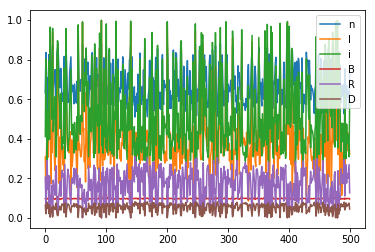

In [40]:
for f in ['n','l','i','B','R','D']:
    plt.plot(range(REPEAT),perfDf[f])
plt.legend(['n','l','i','B','R','D'])
plt.savefig(DEFAULT_ADD+'/Graph/500epics.png', bbox_inches='tight',dpi=300,pad_inches=0.0)

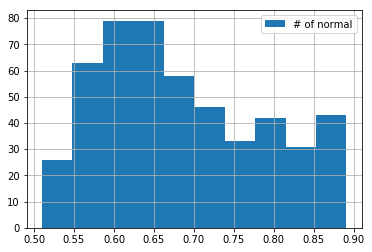

In [39]:
#sns.distplot(perfDf['b'], kde=False)
#plt.axvline(perfDf['b'].mean(), c='r')
#sns.distplot(perfDf['n'], kde=False)
#plt.axvline(perfDf['n'].mean(), c='r')
#perfDf['b'].hist()
perfDf['n'].hist()
plt.legend(['# of normal'])
plt.savefig(DEFAULT_ADD+'/Graph/NormalBroken500epids.png', bbox_inches='tight',dpi=300,pad_inches=0.0)

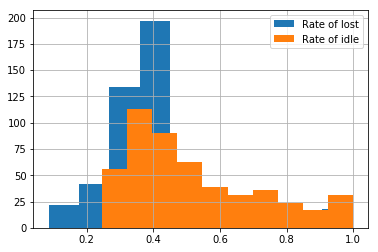

In [41]:
#sns.distplot(perfDf['l'], kde=False)
#plt.axvline(perfDf['l'].mean(), c='r')
#sns.distplot(perfDf['i'], kde=False)
#plt.axvline(perfDf['i'].mean(), c='r')
perfDf['l'].hist()
perfDf['i'].hist()
plt.legend(['Rate of lost', 'Rate of idle'])
plt.savefig(DEFAULT_ADD+'/Graph/LostIdle500epids.png', bbox_inches='tight',dpi=300,pad_inches=0.0)

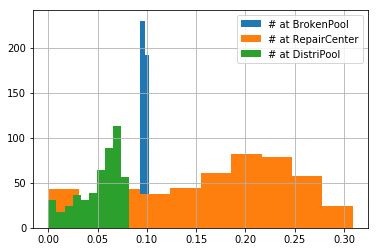

In [42]:
# sns.distplot(perfDf['B'])
# plt.axvline(perfDf['B'].mean(), c='r')
# sns.distplot(perfDf['R'])
# plt.axvline(perfDf['R'].mean(), c='r')
# sns.distplot(perfDf['D'])
# plt.axvline(perfDf['D'].mean(), c='r')
perfDf['B'].hist()
perfDf['R'].hist()
perfDf['D'].hist()
plt.legend(['# at BrokenPool', '# at RepairCenter', '# at DistriPool'])
plt.savefig(DEFAULT_ADD+'/Graph/BPRCDP500epids.png', bbox_inches='tight',dpi=300,pad_inches=0.0)

In [81]:
REPEAT = 30
portionStateDf, portionStateDfLst = pd.DataFrame(), []
perfDf, perfDfLst = pd.DataFrame(), []
for epi in tqdm(range(REPEAT)):
    np.random.seed(epi)
    def getPij(a):
        temp = np.log1p(np.random.rand(A,A))
        return (temp/sum(temp)).T
    Pij = getPij(A)
    ArrLst = np.log1p(np.random.rand(A))
    for smt in np.arange(1,7,1):
        #smt = round(smt, 1)
        for i in np.arange(0.1,4,0.1):
            para = Gamma = i
            B_ = smt
            instance = perfCenODE(A, M, Pij, ArrLst, RhoMtx, Beta, B_, Gamma, Mu, N, Delta, D_)
            return_data, return_perf = instance.getPerf(para)
            return_data['para'], return_perf['para'] = para, para
            return_data['smt'], return_perf['smt'] = smt, smt
            return_data['seed'], return_perf['seed'] = epi, epi
            portionStateDfLst.append(return_data)
            perfDfLst.append(return_perf)
            del instance, return_data, return_perf

portionStateDf = pd.concat(portionStateDfLst, axis=0, ignore_index=True)
perfDf = pd.concat(perfDfLst, axis=0, ignore_index=True)
#portionStateDf.tail()
#perfDf
#portionStateDf.to_csv(DEFAULT_ADD+'/Data/'+'500Epids.csv')
#perfDf.to_csv(DEFAULT_ADD+'/Data/'+'perf500Epids.csv')
#portionStateDf.to_csv(DEFAULT_ADD+'/Data/'+'Gamma0-12.csv')
#perfDf.to_csv(DEFAULT_ADD+'/Data/'+'perfGamma0-12.csv')
portionStateDf.to_csv(DEFAULT_ADD+'/Data/'+'Delta+Mu8.csv')
perfDf.to_csv(DEFAULT_ADD+'/Data/'+'perfDelta+Mu8.csv')

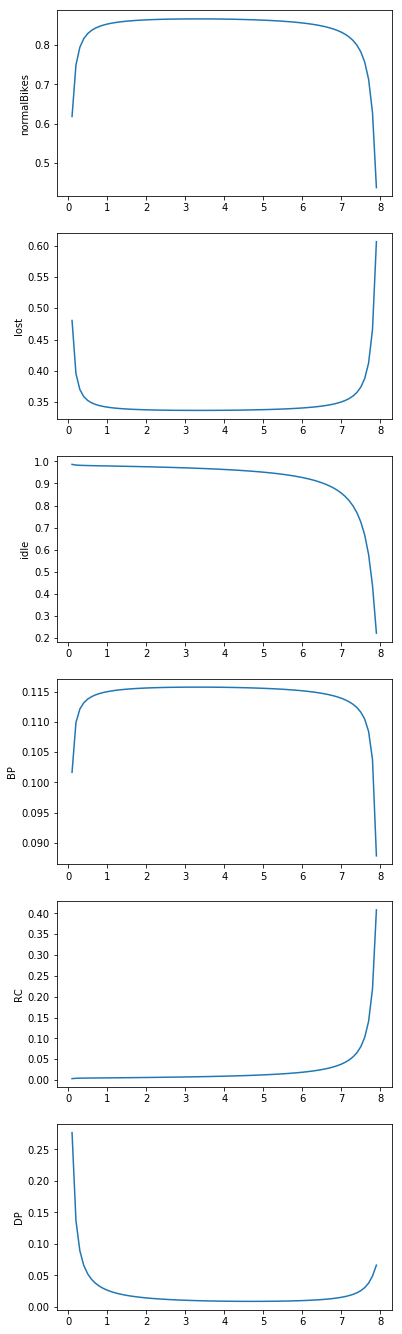

In [82]:
plt.subplots(figsize=(6,28), frameon=False)
plt.margins(0,0)
y_label = ['normalBikes', 'lost', 'idle', 'BP', 'RC', 'DP']
tempdf = perfDf.groupby('para',)
for i,f in enumerate(['n','l','i','B','R','D']):
    plt.subplot(7,1,i+1)
    plt.ylabel(y_label[i])
    #plt.plot(x,data)
    plt.plot(tempdf[f].mean().index, tempdf[f].mean())
#     x, data = [], []
#     for k in result:
#         x.append(k[i][0])
#         data.append(k[i][1])
    
#plt.axis('off')

plt.savefig(DEFAULT_ADD+'/Graph/perfDelta+Mu8.png', bbox_inches='tight',dpi=300,pad_inches=0.0)

In [165]:
A, M = 2, 6
s = time()
result = []
for i in np.arange(0.1,6.0,0.1):
    Mu = i
    Gamma = Delta = (6-Mu)/2
    instance = perfCenODE(A, M, Pij, ArrLst, RhoMtx, Beta, B_, Gamma, Mu, N, Delta, D_)
    result.append(instance.getPerf(Mu))
    #print(instance.n_state)
#     print(instance.getPerf(B_))
#     t = time()
#     print('walltime:', t-s)

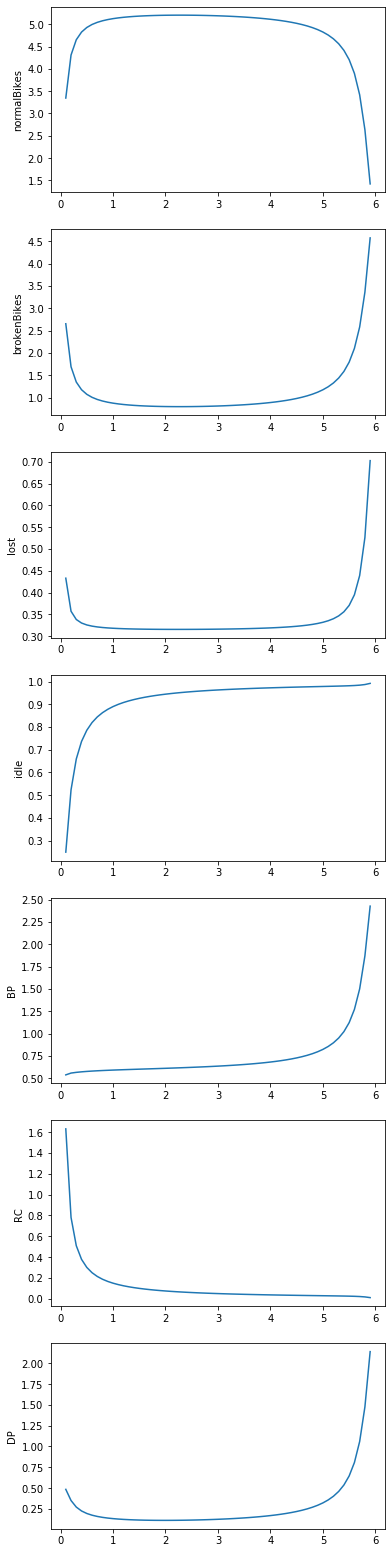

In [166]:
plt.subplots(figsize=(6,28), frameon=False)
plt.margins(0,0)
y_label = ['normalBikes', 'brokenBikes', 'lost', 'idle', 'BP', 'RC', 'DP']
for i in range(7):
    x, data = [], []
    for k in result:
        x.append(k[i][0])
        data.append(k[i][1])
    plt.subplot(7,1,i+1)
    plt.ylabel(y_label[i])
    plt.plot(x,data)
#plt.axis('off')
plt.savefig('/Users/valarian/SJTU/SJTU/毕业论文/中文论文/graph/Mu_B_D_.png', bbox_inches='tight',dpi=300,pad_inches=0.0)

In [168]:
A, M = 2, 6
s = time()
result = []
for i in np.arange(0.1,4.0,0.1):
    Gamma = i
    Delta = 4-Gamma
    instance = perfCenODE(A, M, Pij, ArrLst, RhoMtx, Beta, B_, Gamma, Mu, N, Delta, D_)
    result.append(instance.getPerf(Gamma))
    #print(instance.n_state)
#     print(instance.getPerf(B_))
#     t = time()
#     print('walltime:', t-s)

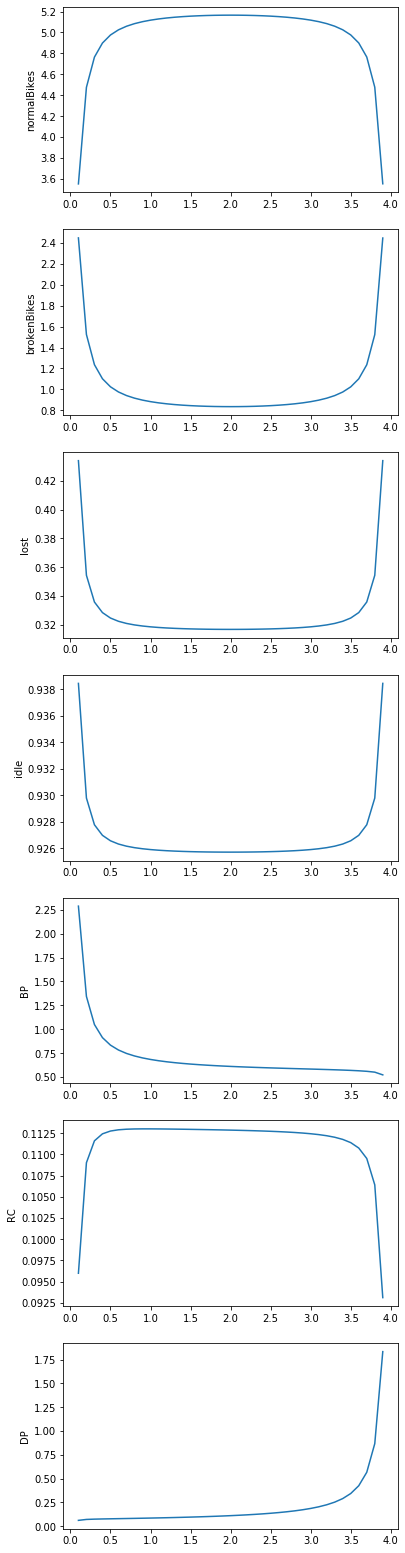

In [169]:
plt.subplots(figsize=(6,28), frameon=False)
plt.margins(0,0)
y_label = ['normalBikes', 'brokenBikes', 'lost', 'idle', 'BP', 'RC', 'DP']
for i in range(7):
    x, data = [], []
    for k in result:
        x.append(k[i][0])
        data.append(k[i][1])
    plt.subplot(7,1,i+1)
    plt.ylabel(y_label[i])
    plt.plot(x,data)
#plt.axis('off')
plt.savefig('/Users/valarian/SJTU/SJTU/毕业论文/中文论文/graph/Delta+Gamma=4.0.png', bbox_inches='tight',dpi=300,pad_inches=0.0)

In [163]:
A, M = 2, 6
s = time()
result = []
for i in np.arange(0.1,3.0,0.1):
    N = 2
    Mu = i
    instance = perfCenODE(A, M, Pij, ArrLst, RhoMtx, Beta, B_, Gamma, Mu, N, Delta, D_)
    result.append(instance.getPerf(Mu))
    #print(instance.n_state)
#     print(instance.getPerf(B_))
#     t = time()
#     print('walltime:', t-s)

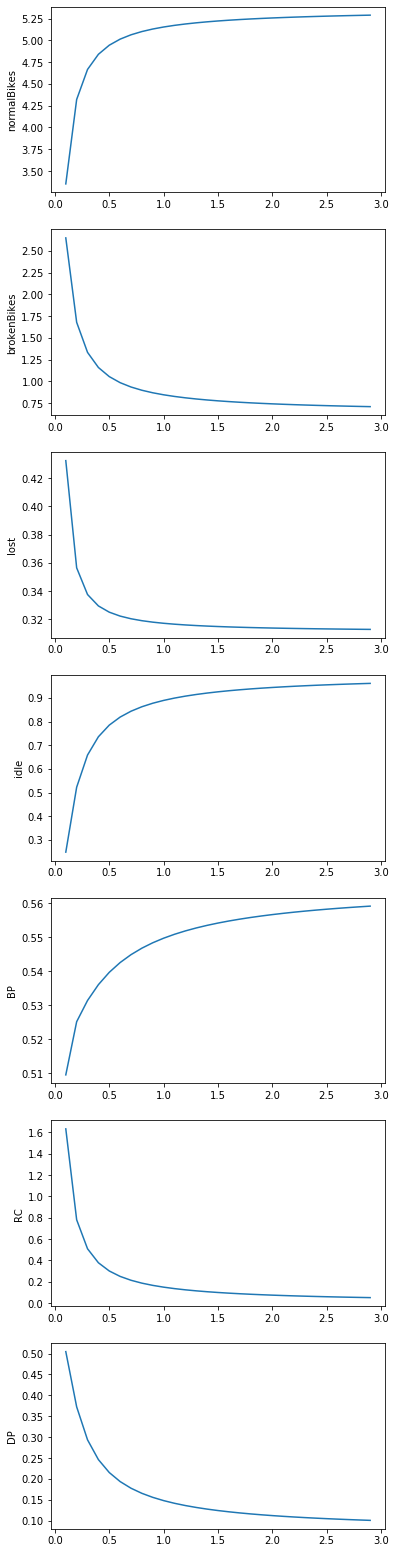

In [164]:
plt.subplots(figsize=(6,28), frameon=False)
plt.margins(0,0)
y_label = ['normalBikes', 'brokenBikes', 'lost', 'idle', 'BP', 'RC', 'DP']
for i in range(7):
    x, data = [], []
    for k in result:
        x.append(k[i][0])
        data.append(k[i][1])
    plt.subplot(7,1,i+1)
    plt.ylabel(y_label[i])
    plt.plot(x,data)
#plt.axis('off')
plt.savefig('/Users/valarian/SJTU/SJTU/毕业论文/中文论文/graph/Mu3.0N2.png', bbox_inches='tight',dpi=300,pad_inches=0.0)

In [159]:
A, M = 2, 6
s = time()
result = []
for i in np.arange(0.1,10.0,0.1):
    Delta = 2.0
    Gamma = i
    instance = perfCenODE(A, M, Pij, ArrLst, RhoMtx, Beta, B_, Gamma, Mu, N, Delta, D_)
    result.append(instance.getPerf(Gamma))
    #print(instance.n_state)
#     print(instance.getPerf(B_))
#     t = time()
#     print('walltime:', t-s)

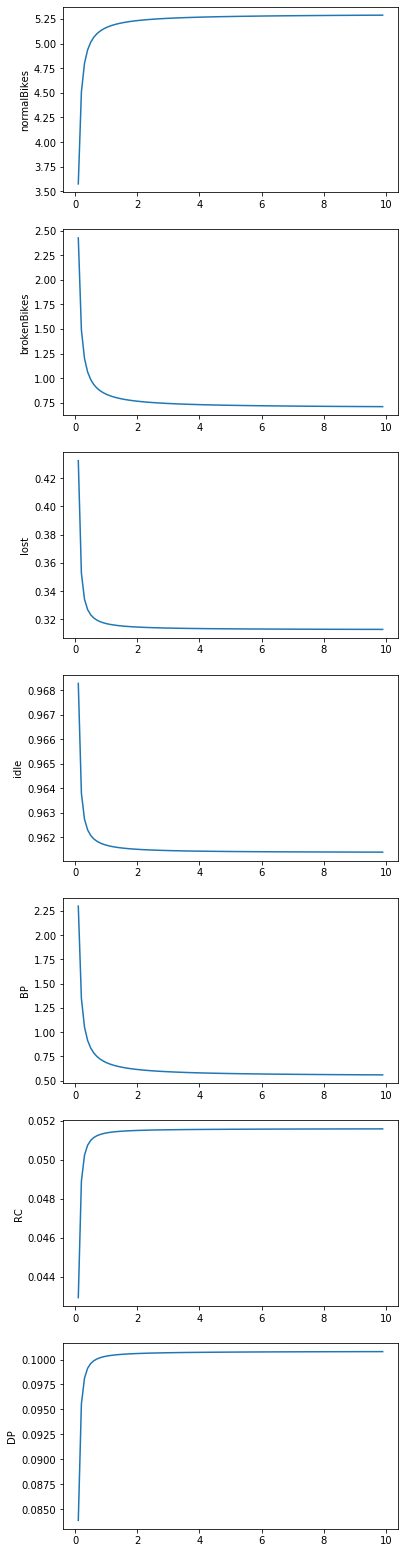

In [160]:
plt.subplots(figsize=(6,28), frameon=False)
plt.margins(0,0)
y_label = ['normalBikes', 'brokenBikes', 'lost', 'idle', 'BP', 'RC', 'DP']
for i in range(7):
    x, data = [], []
    for k in result:
        x.append(k[i][0])
        data.append(k[i][1])
    plt.subplot(7,1,i+1)
    plt.ylabel(y_label[i])
    plt.plot(x,data)
#plt.axis('off')
plt.savefig('/Users/valarian/SJTU/SJTU/毕业论文/中文论文/graph/Delta2Gamma0.1-10.png', bbox_inches='tight',dpi=300,pad_inches=0.0)

In [176]:
A, M = 2, 6
s = time()
result = []
for i in np.arange(1,7,1):
    D_ = i
    instance = perfCenODE(A, M, Pij, ArrLst, RhoMtx, Beta, B_, Gamma, Mu, N, Delta, D_)
    result.append(instance.getPerf(D_))
    #print(instance.n_state)
#     print(instance.getPerf(B_))
#     t = time()
#     print('walltime:', t-s)

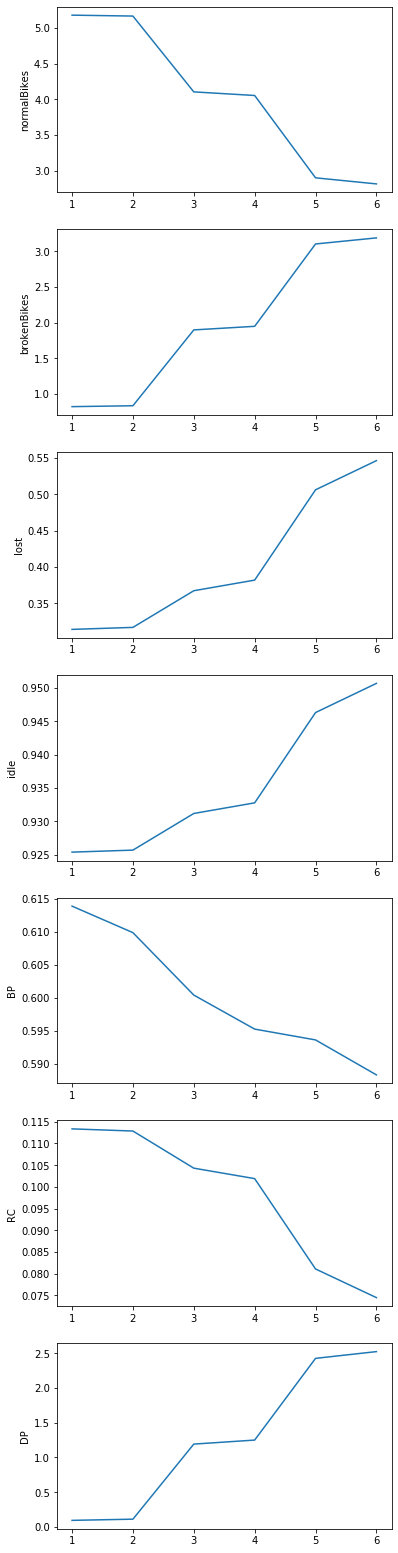

In [177]:
plt.subplots(figsize=(6,28), frameon=False)
plt.margins(0,0)
y_label = ['normalBikes', 'brokenBikes', 'lost', 'idle', 'BP', 'RC', 'DP']
for i in range(7):
    x, data = [], []
    for k in result:
        x.append(k[i][0])
        data.append(k[i][1])
    plt.subplot(7,1,i+1)
    plt.ylabel(y_label[i])
    plt.plot(x,data)
#plt.axis('off')
plt.savefig('/Users/valarian/SJTU/SJTU/毕业论文/中文论文/graph/Dbar1-6.png', bbox_inches='tight',dpi=300,pad_inches=0.0)

In [ ]:
# historical version of function
def getPossSet():
    possSet = []
    #print(inLst)
    inLst, outLst = deque([i for i in range(0, M+1, B_)]), []
    possSet = inLst.copy()
    while inLst:
        #print(inLst)
        _ = inLst.popleft()
        for i in range(_, -1, -D_):
            out = M-i
            temp = i
            while out>=B_:
                temp += B_
                if temp not in possSet:
                    inLst.append(temp)
                out -= B_
            possSet.append(i)
    #print('getPossSet done!')
    return set(possSet)
getPossSet()